On cherche ici à matcher les images avant et apres ayant la plus petite différence d'angle d'incidence pour minimiser les déformations géométriques entre les images

In [1]:
import rasterio as rio
import geopandas as gpd
import fiona
import os
import pickle
# enable kml file reading for geopandas
from shapely.geometry import box, Polygon
import pandas as pd
import numpy as np
import leafmap.foliumap as leafmap # use folium backend
import rioxarray as rioxr
import matplotlib.pyplot as plt
from typing import List, Union, Dict
from pathlib import Path
import itertools
pd.options.display.max_columns = 50

In [5]:
from src.config import *
from src.io.utils_io import load_maxar_items, load_rs_path_toy, load_roi_town, check_dir, make_path
from src.utils import create_bbox, get_maxar_items_on_roi
from src.rs_processing.processing import crop_rs_on_shape
from src.stac.utils_stac import get_nearest_match_geometry_view

In [3]:
town_test = "Talat Nyaaqoub"
date_event = '2023-09-09'
type_item="pan_analytic"
buffer_size=200

In [41]:
maxar_items = load_maxar_items(type_item=type_item)

In [42]:
town = load_roi_town()

In [43]:
town.geometry.buffer(buffer_size).values[0].bounds

(547709.1304341872, 3441774.1374146263, 548109.1304341872, 3442174.1374146263)

## Explo

In [175]:
town.geometry = create_bbox(town.geometry, buffer_size)

In [176]:
match_town = {}
for name in town.town_name.unique(): 
    match_town[name] = {}
    items = get_maxar_items_on_roi(maxar_items, town[town.town_name == name], th=0.9, s_bbox=None)
    for temp, v in zip(["after", "before"], [1, 0]):
        match_town[name][temp] = items[items.after_event == v].reset_index(drop=True)

INFO:src.utils:found 6 maxar items
INFO:src.utils:found 5 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 4 maxar items
INFO:src.utils:found 2 maxar items
INFO:src.utils:found 11 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 6 maxar items


In [11]:
match_town['Adassil']["before"]["view_incidence_angle"]

0    74.6
1    58.8
2    71.5
3    65.3
4    73.2
Name: view_incidence_angle, dtype: float64

In [12]:
for name, temp_df in match_town.items(): 
    print(name)
    b_arr, b_arr_indices =  list(temp_df["before"]["view_incidence_angle"]),  list(temp_df["before"].index)
    a_arr, a_arr_indices =  list(temp_df["after"]["view_incidence_angle"]), list(temp_df["after"].index)
    print(b_arr)
    print(a_arr)

Adassil
[74.6, 58.8, 71.5, 65.3, 73.2]
[52.8]
Tafeghaghte
[68.8, 59.1, 58.0]
[40.1, 61.9]
Mejdid
[74.6, 58.8, 71.5, 65.3, 73.2]
[52.8]
Amzi
[68.4, 59.4]
[39.9, 62.3]
Tinzert
[73.9]
[52.0]
Taroudant
[60.0, 62.8, 66.5, 58.0, 61.1, 69.7, 57.7, 67.2, 58.1, 75.5]
[41.6]
Talat Nyaaqoub
[79.8, 67.9, 59.6, 63.3]
[52.2, 62.7]
Tassouante
[79.8, 67.9, 59.6, 63.3]
[52.2, 62.7]


* On essaye de matcher pour chaque village le match (before, after) avec la plus petite différence d'angle d'incidence

In [13]:
nearest = {}

for name, temp_df in match_town.items(): 
    nearest[name] = {}
    print(name)
    b_arr, b_arr_indices =  list(temp_df["before"]["view_incidence_angle"]),  list(temp_df["before"].index)
    a_arr, a_arr_indices =  list(temp_df["after"]["view_incidence_angle"]), list(temp_df["after"].index)
    prod_cart_values = [np.abs(float(_[0]) - float(_[1])) for _ in itertools.product(b_arr, a_arr)]
    prod_cart_indices = [_ for _ in itertools.product(b_arr_indices, a_arr_indices)]

    nearest_neigh, idx_nearest_neigh = np.min(prod_cart_values), np.argmin(prod_cart_values)
    print(f"min for {nearest_neigh} at {prod_cart_indices[idx_nearest_neigh]}")  

    # get df associated to best match
    nearest[name]["before"] = match_town[name]["before"].iloc[prod_cart_indices[idx_nearest_neigh][0]].to_frame().T
    nearest[name]["after"] = match_town[name]["after"].iloc[prod_cart_indices[idx_nearest_neigh][1]].to_frame().T
    print("---")

Adassil
min for 6.0 at (1, 0)
---
Tafeghaghte
min for 2.799999999999997 at (1, 1)
---
Mejdid
min for 6.0 at (1, 0)
---
Amzi
min for 2.8999999999999986 at (1, 1)
---
Tinzert
min for 21.900000000000006 at (0, 0)
---
Taroudant
min for 16.1 at (6, 0)
---
Talat Nyaaqoub
min for 0.5999999999999943 at (3, 1)
---
Tassouante
min for 0.5999999999999943 at (3, 1)
---


## Pipeline

In [ ]:
get_

off-nadir ?? cf DCVA

In [45]:
nearest = get_nearest_match_angle_view(town, maxar_items, s_bbox=100)

INFO:src.utils:found 6 maxar items
INFO:src.utils:found 5 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 4 maxar items
INFO:src.utils:found 2 maxar items
INFO:src.utils:found 11 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 6 maxar items


Adassil
Tafeghaghte
Mejdid
Amzi
Tinzert
Taroudant
Talat Nyaaqoub
Tassouante


In [46]:
print(nearest["Talat Nyaaqoub"]["before"]["view_incidence_angle"])
print(nearest["Talat Nyaaqoub"]["after"]["view_incidence_angle"])

3    63.3
Name: view_incidence_angle, dtype: object
1    62.7
Name: view_incidence_angle, dtype: object


In [47]:
nearest["Amzi"]["before"]["view_incidence_angle"]

1    59.4
Name: view_incidence_angle, dtype: object

In [48]:
nearest["Amzi"]["after"]["view_incidence_angle"]

1    62.3
Name: view_incidence_angle, dtype: object

In [ ]:
b_rs_path = nearest[town_test]["before"]["href"].item()
a_rs_path = nearest[town_test]["after"]["href"].item()

new_path_dir = check_dir(interim_dir_path, type_item, town_test, "nearest")

In [52]:
shape = town[town.town_name == town_test].geometry.item()

In [125]:
b_rs_name = Path(b_rs_path).stem
a_rs_name = Path(a_rs_path).stem

#b_crop_path = crop_rs_on_shape(b_rs_path, shape, make_path(f"crop_{buffer_size}_{b_rs_name}.tif", new_path_dir))
#a_crop_path = crop_rs_on_shape(a_rs_path, shape, make_path(f"crop_{buffer_size}_{a_rs_name}.tif", new_path_dir))

### New towns

In [132]:
town_test = "Talat Nyaaqoub"
type_item = "ms_analytic"
s_buffer = 300

In [110]:
nearest = get_nearest_match_angle_view(town, type_item="ms_analytic", s_bbox=s_buffer)

INFO:src.utils:found 6 maxar items
INFO:src.utils:found 5 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 4 maxar items
INFO:src.utils:found 2 maxar items
INFO:src.utils:found 11 maxar items
INFO:src.utils:found 6 maxar items
INFO:src.utils:found 6 maxar items


Adassil
Tafeghaghte
Mejdid
Amzi
Tinzert
Taroudant
Talat Nyaaqoub
Tassouante


In [143]:
talat = get_maxar_items_on_roi(maxar_items, town[town.town_name == town_test], th=0.2, s_bbox=s_buffer)

INFO:src.utils:found 6 maxar items


In [144]:
talat

,id,type,title,href,datetime,platform,gsd,catalog_id,utm_zone,quadkey,view_off_nadir,view_azimuth,view_incidence_angle,view_sun_azimuth,view_sun_elevation,proj_epsg,grid_code,data_area,clouds_area,clouds_percent,geometry_bbox,after_event,town_name,geometry,intersec_roi_perc
1,29/120202021131/10300500E4F91800,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2023-09-10 11:45:02Z,WV02,0.64,10300500E4F91800,29,120202021131,33.099998,278.500000,52.2,155.6,62.1,32629,MXRA-Z29-120202021131,28.203125,0.000000,0.0,"[574843.75, 3424843.75, 580156.25, 3430156.25]",1,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0
2,29/120202021131/10300500E4F92300,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2023-09-11 11:08:50Z,WV02,0.55,10300500E4F92300,29,120202021131,24.200001,114.199997,62.7,140.1,57.6,32629,MXRA-Z29-120202021131,28.203125,0.000000,0.0,"[574843.75, 3424843.75, 580156.25, 3430156.25]",1,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0
0,29/120202021131/103001008244DA00,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-09 11:28:17Z,WV02,0.47,103001008244DA00,29,120202021131,9.100000,155.600006,79.8,129.4,68.1,32629,MXRA-Z29-120202021131,19.500000,2.699219,14.0,"[576451.1108398438, 3424843.75, 580156.25, 343...",0,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0
3,29/120202021131/10400100405FEB00,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-08-17 11:52:18Z,WV03,0.34,10400100405FEB00,29,120202021131,20.000000,294.200012,67.9,147.2,69.7,32629,MXRA-Z29-120202021131,12.203125,0.000000,0.0,"[574843.75, 3427733.7646484375, 580156.25, 343...",0,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0
4,29/120202021131/1040010045AE4B00,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2018-12-19 11:29:11Z,WV03,0.38,1040010045AE4B00,29,120202021131,27.400000,74.300003,59.6,163.1,33.8,32629,MXRA-Z29-120202021131,9.500000,0.000000,0.0,"[574843.75, 3427446.8994140625, 578612.3657226...",0,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0
5,29/120202021131/1040010077691A00,image/tiff; application=geotiff; profile=cloud...,Panchromatic Image,https://maxar-opendata.s3.amazonaws.com/events...,2022-06-23 11:12:12Z,WV03,0.36,1040010077691A00,29,120202021131,24.200001,127.400002,63.3,106.8,70.2,32629,MXRA-Z29-120202021131,28.203125,0.000000,0.0,"[574843.75, 3424843.75, 580156.25, 3430156.25]",0,Talat Nyaaqoub,"POLYGON ((577644.644 3428429.694, 577644.644 3...",1.0


In [111]:
b_path = nearest["Talat Nyaaqoub"]["before"]["href"].item()
a_path = nearest["Talat Nyaaqoub"]["after"]["href"].item()

In [112]:
b_path

'https://maxar-opendata.s3.amazonaws.com/events/Morocco-Earthquake-Sept-2023/ard/29/120202021131/2022-06-23/1040010077691A00-ms.tif'

In [125]:
shape = create_bbox(town[town.town_name == "Talat Nyaaqoub"], s_buffer=s_buffer)

In [114]:
town_test = "Talat Nyaaqoub"

In [115]:
out_dir_pan_b = check_dir(interim_dir_path, type_item, town_test, "before")
out_dir_pan_a = check_dir(interim_dir_path, type_item, town_test, "after")

In [116]:
out_dir_pan_a

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/interim/ms_analytic/Talat Nyaaqoub/after'

In [120]:
b_path

'https://maxar-opendata.s3.amazonaws.com/events/Morocco-Earthquake-Sept-2023/ard/29/120202021131/2022-06-23/1040010077691A00-ms.tif'

In [119]:
b_rs_name = Path(b_path).stem
a_rs_name = Path(a_path).stem

In [126]:
tmp_dir = os.path.join(os.path.expanduser("~/Documents/Projects/building_damage/registration"))

In [133]:
b_img = crop_rs_on_shape(b_path, shape, out_path=os.path.join(tmp_dir, f"{s_buffer}_{b_rs_name}.tif"))

In [134]:
b_img

'/home/rustt/Documents/Projects/building_damage/registration/300_1040010077691A00-ms.tif'

In [137]:
a_rs = rioxr.open_rasterio(a_img)
b_rs = rioxr.open_rasterio(b_img)

In [142]:
np.max(a_rs.sel(band=1).data)

5632

In [139]:
b_rs.shape

(8, 424, 424)

In [135]:
a_img = crop_rs_on_shape(a_path, shape, out_path=os.path.join(tmp_dir, f"{s_buffer}_{a_rs_name}.tif"))

In [136]:
a_img

'/home/rustt/Documents/Projects/building_damage/registration/300_10300500E4F92300-ms.tif'

In [104]:
print(nearest['Talat Nyaaqoub']['before']["platform"].item(), nearest['Talat Nyaaqoub']['before']["gsd"].item())
print(nearest['Talat Nyaaqoub']['after']["platform"].item(), nearest['Talat Nyaaqoub']['after']["gsd"].item())

WV03 0.360000014305115
WV02 0.550000011920929


In [103]:
nearest['Talat Nyaaqoub']['before']["gsd"]

3    0.36
Name: gsd, dtype: object

In [69]:
type_item

'pan_analytic'

In [72]:
b_img

<xarray.DataArray (band: 1, y: 566, x: 565)>
[319790 values with dtype=uint16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.778e+05 5.778e+05 5.778e+05 ... 5.78e+05 5.78e+05
  * y            (y) float64 3.429e+06 3.429e+06 ... 3.429e+06 3.429e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [70]:
b_img = rioxr.open_rasterio(os.path.join(out_dir_pan_b, f"{buffer_size}_{b_rs_name}.tif"))
a_img = rioxr.open_rasterio(os.path.join(out_dir_pan_a, f"{buffer_size}_{a_rs_name}.tif"))

(-0.5, 383.5, 383.5, -0.5)

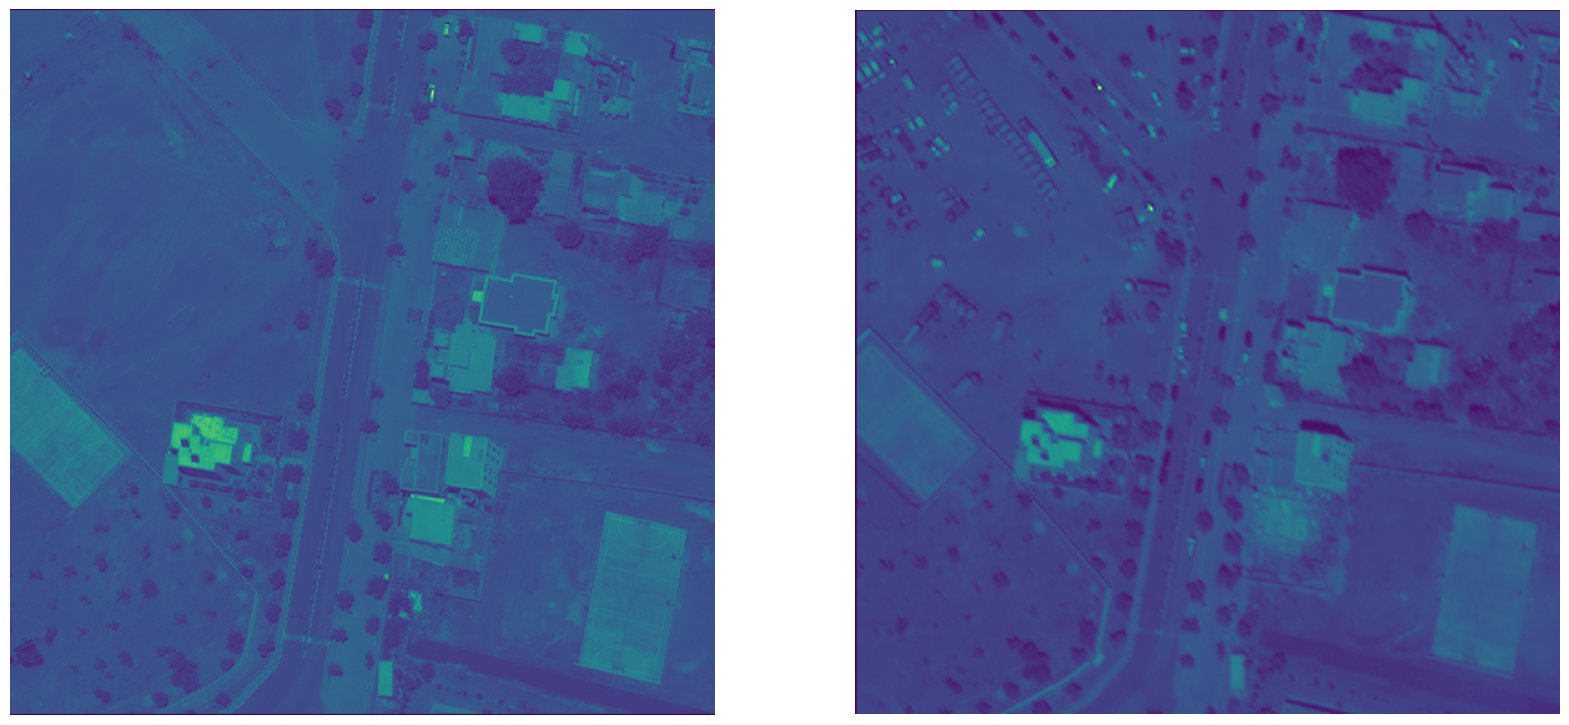

In [74]:
plt.figure(figsize=(20, 20))
plt.subplot(1, 2, 1)
plt.imshow(b_img.sel(band=1).data)
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(a_img.sel(band=1).data)
plt.axis("off")

In [24]:
os.path.join(out_dir_pan_b, f"{buffer_size}_{b_rs_name}.tif")

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/interim/visual/Tafeghaghte/before/200_1040010045AE4B00-visual.tif'

In [25]:
os.path.join(out_dir_pan_a, f"{buffer_size}_{a_rs_name}.tif")

'/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/interim/visual/Tafeghaghte/after/200_10300500E4F92300-visual.tif'

In [17]:
rs_b_repro = a_img.rio.reproject_match(b_img)

In [18]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [20]:
print_raster(a_img) 
print('----')
print_raster(b_img)
print('----')
print_raster(rs_b_repro)

shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629

----
shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629

----
shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629



In [21]:
rs_a_repro = b_img.rio.reproject_match(a_img)

In [22]:
def print_raster(raster):
    print(
        f"shape: {raster.rio.shape}\n"
        f"resolution: {raster.rio.resolution()}\n"
        f"bounds: {raster.rio.bounds()}\n"
        f"CRS: {raster.rio.crs}\n"
    )

In [23]:
print_raster(a_img) 
print('----')
print_raster(b_img)
print('----')
print_raster(rs_a_repro)

shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629

----
shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629

----
shape: (657, 656)
resolution: (0.30517578125, -0.30517578125)
bounds: (577844.5434570312, 3428629.4555664062, 578044.7387695312, 3428829.9560546875)
CRS: EPSG:32629



In [147]:
a_img.shape

(1, 384, 384)

In [110]:
import cv2

In [149]:
def compute_sift(b_img, a_img, n_match):

    # Turn Images to grayscale
    def to_gray(color_img):
        gray = cv2.cvtColor(color_img, cv2.COLOR_BGR2GRAY)
        return gray

    train_img = a_img.copy()
    query_img = b_img.copy()
    if (a_img.shape[2] > 1) and (b_img.shape[2] > 1):
        train_img_gray = to_gray(train_img)
        query_img_gray = to_gray(query_img)
    else:
        train_img = cv2.normalize(train_img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
        query_img = cv2.normalize(query_img, None, 255, 0, cv2.NORM_MINMAX, cv2.CV_8U)
        train_img_gray = train_img.copy()
        query_img_gray = query_img.copy()

    # Initialise SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()
        
    # Generate SIFT keypoints and descriptors
    train_kp, train_desc = sift.detectAndCompute(train_img_gray, None)
    query_kp, query_desc = sift.detectAndCompute(query_img_gray, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = bf.match(train_desc, query_desc)
    
    # Sort the matches in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    match_img = cv2.drawMatches(
        train_img, train_kp,
        query_img, query_kp,
        matches[:n_match], query_img.copy(), flags=0)
    
    plt.figure(3, figsize=(20, 20))
    plt.imshow(match_img)
    plt.show()

In [150]:
print(b_img.transpose(1, 2, 0).shape)
print(a_img.transpose(1, 2, 0).shape)

(566, 565, 1)
(384, 384, 1)


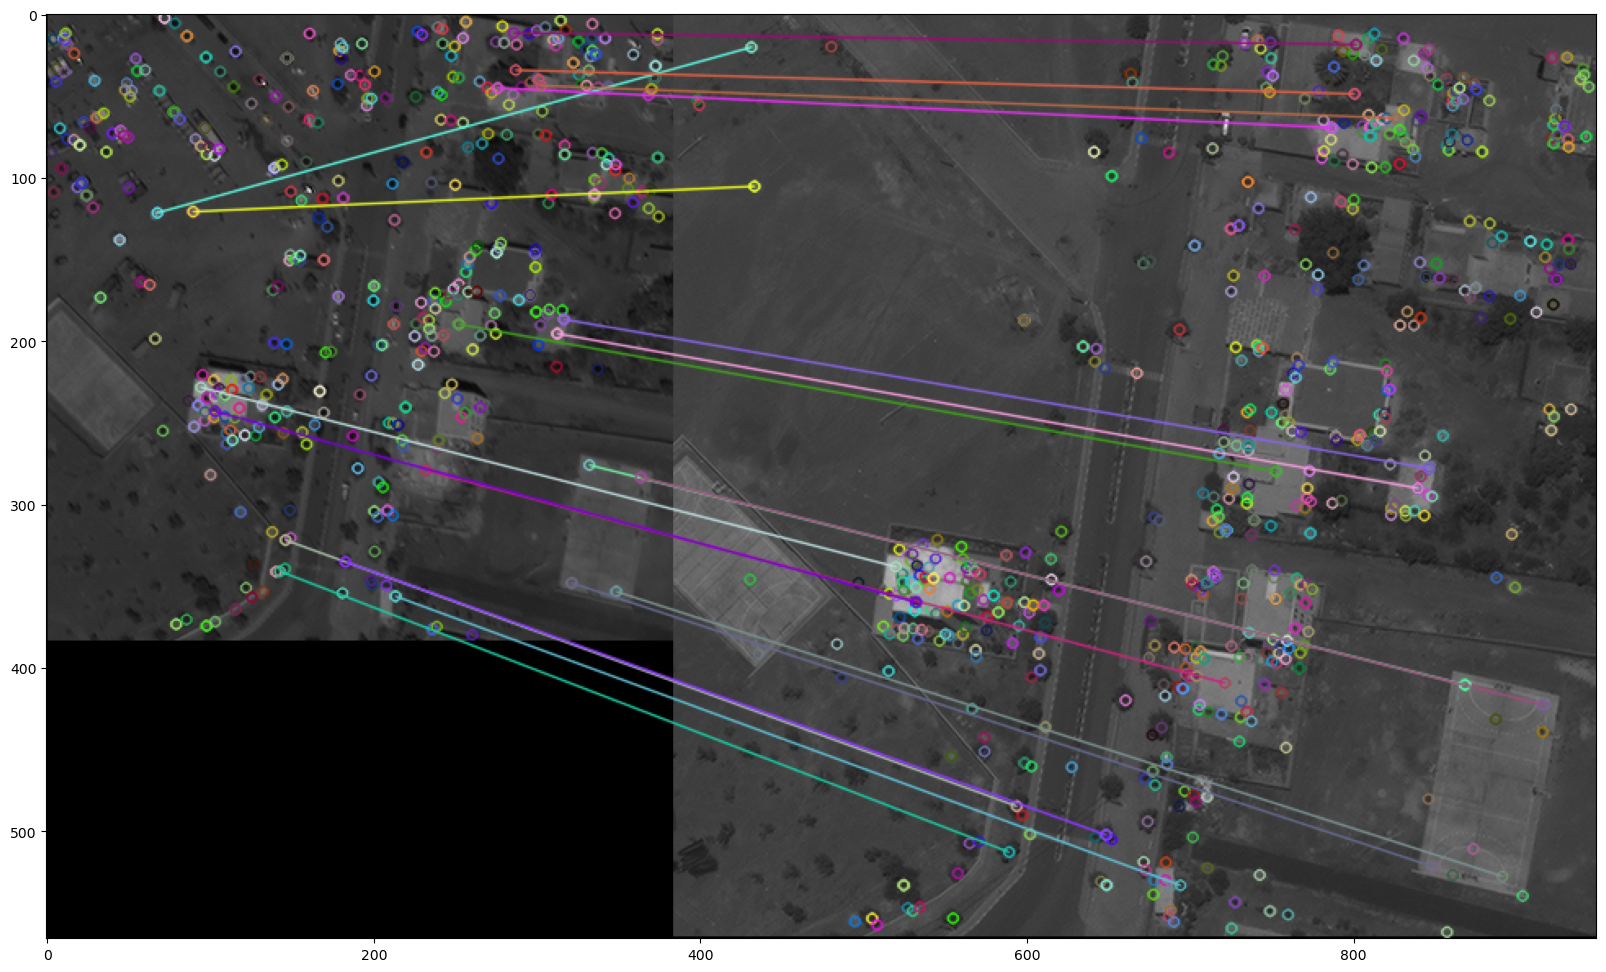

In [151]:
compute_sift(b_img.transpose(1, 2, 0), a_img.transpose(1, 2, 0), n_match=20)

In [89]:
a_img.shape

(3, 657, 656)

### Create img test for pan sharpening and co-registration

In [ ]:
type_item = 'ms_analytic'
s_buffer=100
town_test = "Talat Nyaaqoub"

maxar_items = load_maxar_items(type_item=type_item)
town = load_roi_town(buffer_size=s_buffer)

out_path_psh_b = check_dir(processed_dir_path, "pan_sharp", town_test, "before")
out_path_psh_a = check_dir(processed_dir_path, "pan_sharp", town_test, "after")

nearest = get_nearest_match_angle_view(town, maxar_items, s_bbox=None)

In [164]:
print(out_path_psh_b)
print(out_path_psh_a)

/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/processed/pan_sharp/Talat Nyaaqoub/before
/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/processed/pan_sharp/Talat Nyaaqoub/after


In [161]:
b_rs_path = nearest[town_test]["before"]["href"].item()
a_rs_path = nearest[town_test]["after"]["href"].item()

In [ ]:
#b_img = crop_rs_on_shape(b_path, shape)

In [ ]:
#a_img = crop_rs_on_shape(a_path, shape)

## Open arosics output

In [88]:
path = "/home/rustt/Documents/Projects/building_damage/morocco_damage_building/data/processed/pan_analytic/registration/200_1040010077691A00-pan__shifted_to__200_10300500E4F92300-pan.bsq"

In [89]:
rs = rioxr.open_rasterio(path)

In [90]:
rs.rio.crs

CRS.from_epsg(32629)

In [92]:
rs.shape

(1, 565, 564)

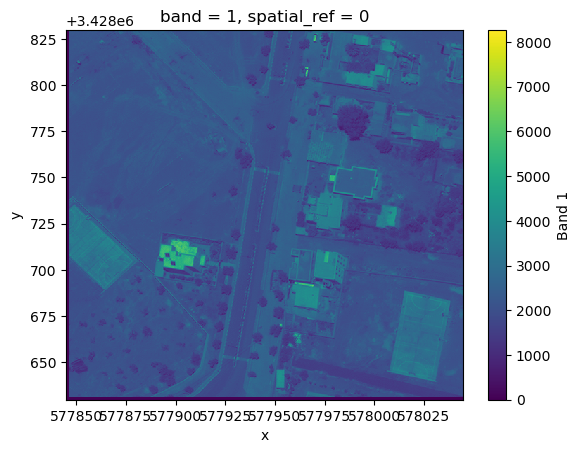

In [91]:
rs.sel(band=1).plot()

ca parait pas mal ! qgis visu => deplacement transversale ok!

quantifier deplacements ?

local vs global


realiser alignement pour autres images

* test building extraction with osm / google vs pretrained models or train model
* cd changement ? 

ref : after
target : before

good way to do it ??

```
arosics local 200_10300500E4F92300-pan.tif 200_1040010077691A00-pan.tif 50
```

https://danschef.git-pages.gfz-potsdam.de/arosics/doc/about.html#feature-overview

quelles sont les hypothèses de depart sur les images ?a_img- a ton besoin de preprocessing ?


-> see alignement avce batiments ?
-> changeos